In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# physio_path = "/content/drive/MyDrive/Colab Notebooks/FYP/data/Exp4/Exp4/Preprocessed/Physio/periods/features_segm_1.csv"
# driving_path = "/content/drive/MyDrive/Colab Notebooks/FYP/data/Exp4/Exp4/Preprocessed/Driving/features_tor_10s_30s_rows.csv"
# pvt_path = "/content/drive/MyDrive/Colab Notebooks/FYP/data/Exp4/Exp4/Preprocessed/PVT/data_PVT_no_outliers_mean_sd.csv"

In [3]:
driving_path = "../Exp4/Preprocessed/Driving/features_tor_10s_30s_rows.csv"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(driving_path)

print(data.shape)

(58, 15)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   subject_id             58 non-null     int64  
 1   label_sleep            58 non-null     int64  
 2   label_first_scenario   58 non-null     object 
 3   label_time_exp         58 non-null     int64  
 4   period                 58 non-null     object 
 5   TO_Decision_Rural      58 non-null     int64  
 6   TO_RT_Rural            58 non-null     float64
 7   TO_MaxSWA_Rural        58 non-null     float64
 8   TO_ReengageTime_Rural  40 non-null     float64
 9   TO_MaxBraking_Rural    58 non-null     float64
 10  TO_Decision_Urban      49 non-null     float64
 11  TO_RT_Urban            49 non-null     float64
 12  TO_MaxSWA_Urban        49 non-null     float64
 13  TO_ReengageTime_Urban  39 non-null     float64
 14  TO_MaxBraking_Urban    49 non-null     float64
dtypes: float

In [6]:
data.head()

,subject_id,label_sleep,label_first_scenario,label_time_exp,period,TO_Decision_Rural,TO_RT_Rural,TO_MaxSWA_Rural,TO_ReengageTime_Rural,TO_MaxBraking_Rural,TO_Decision_Urban,TO_RT_Urban,TO_MaxSWA_Urban,TO_ReengageTime_Urban,TO_MaxBraking_Urban
0,1,0,Countryside,16,Country,1,2.450,5.0,12.399,100.0,1.0,1.484,1.0,9.900,100.0
1,2,1,Urban,16,Country,4,2.900,2.0,3.233,0.0,NaN,NaN,NaN,NaN,NaN
2,3,0,Countryside,16,Country,1,2.233,7.0,25.767,100.0,1.0,2.918,5.0,14.068,95.2
3,4,1,Countryside,16,Country,4,1.665,37.0,NaN,100.0,1.0,1.467,10.0,NaN,100.0
4,5,0,Countryside,10,Country,1,1.467,6.0,3.750,100.0,NaN,NaN,NaN,NaN,NaN


In [7]:
label_counts = data["label_sleep"].value_counts()
print(label_counts)

label_sleep
1    31
0    27
Name: count, dtype: int64


C:\Users\kahch\AppData\Local\Temp\ipykernel_41788\3141730654.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


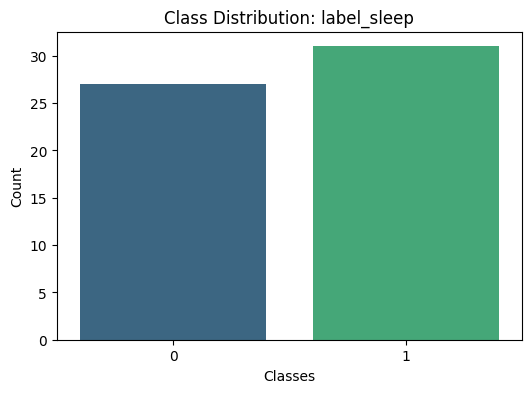

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Class Distribution: label_sleep")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

#Data Preprocessing

In [ ]:
columns_to_exclude = data.columns[data.isnull().mean() > 0.5]
data = data.drop(columns=columns_to_exclude)

data.replace([np.inf, -np.inf], np.nan, inplace=True)

numerical_data = data.select_dtypes(include=['number'])

missing_values = numerical_data.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

data.fillna(numerical_data.mean(), inplace=True)

missing_after = data.isnull().sum()
print("\nMissing Values After Filling:\n", missing_after[missing_after > 0])

if missing_after.sum() == 0:
    print("\nAll missing values have been successfully filled!")
else:
    print("\nThere are still missing values in the dataset.")

Missing Values:
 TO_ReengageTime_Rural    18
TO_Decision_Urban         9
TO_RT_Urban               9
TO_MaxSWA_Urban           9
TO_ReengageTime_Urban    19
TO_MaxBraking_Urban       9
dtype: int64

Missing Values After Filling:
 Series([], dtype: int64)

All missing values have been successfully filled!


In [10]:
data["label_first_scenario"] = data["label_first_scenario"].map({"Countryside": 0, "Urban": 1})
data["period"] = data["period"].map({"Country": 0, "Urban": 1})

print("\n'label_first_scenario' Column After Encoding:\n", data["label_first_scenario"].head())
print("\n'period' Column After Encoding:\n", data["period"].head())


'label_first_scenario' Column After Encoding:
 0    0
1    1
2    0
3    0
4    0
Name: label_first_scenario, dtype: int64

'period' Column After Encoding:
 0    0
1    0
2    0
3    0
4    0
Name: period, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data["label_sleep"] = label_encoder.fit_transform(data["label_sleep"])

print("Encoded Labels:\n", data["label_sleep"].unique())

Encoded Labels:
 [0 1]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

X = data.drop(columns=['subject_id', 'label_sleep']).values
y = data['label_sleep'].values

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Training Set Size: {x_train.shape}")
print(f"Testing Set Size: {x_test.shape}")

scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.transform(x_test)

Training Set Size: (46, 13)
Testing Set Size: (12, 13)


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

input_size = x_train_norm.shape[1]
output_size = y_train.shape[1]

embedding_dim = 32
input_embeddings = layers.Input(shape=(input_size,))
embeddings = layers.Embedding(input_dim=1000, output_dim=embedding_dim)(input_embeddings)

embeddings = layers.Reshape((input_size, embedding_dim))(embeddings)

self_attention = layers.MultiHeadAttention(num_heads=4, key_dim=embedding_dim)(embeddings, embeddings)
self_attention = layers.Dropout(0.1)(self_attention)
self_attention = layers.LayerNormalization(epsilon=1e-6)(self_attention + embeddings)

intersample_attention = layers.MultiHeadAttention(num_heads=4, key_dim=embedding_dim)(self_attention, self_attention)
intersample_attention = layers.Dropout(0.1)(intersample_attention)
intersample_attention = layers.LayerNormalization(epsilon=1e-6)(intersample_attention + self_attention)

flattened = layers.Flatten()(intersample_attention)
dense_1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(flattened)
dropout_1 = layers.Dropout(0.5)(dense_1)
output = layers.Dense(output_size, activation='sigmoid')(dropout_1)

model = models.Model(inputs=input_embeddings, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    x_train_norm, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test_norm, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)


val_loss, val_accuracy = model.evaluate(x_test_norm, y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

y_pred = model.predict(x_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 309ms/step - accuracy: 0.2862 - loss: 3.0493 - val_accuracy: 0.8333 - val_loss: 2.7681
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4751 - loss: 2.9491 - val_accuracy: 0.5833 - val_loss: 2.5584
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6327 - loss: 2.5760 - val_accuracy: 0.4167 - val_loss: 2.6107
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6390 - loss: 2.5840 - val_accuracy: 0.4167 - val_loss: 2.5422
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6245 - loss: 2.4658 - val_accuracy: 0.5833 - val_loss: 2.4958
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.6182 - loss: 2.4314 - val_accuracy: 0.5833 - val_loss: 2.4842
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6929 - loss: 2.3898 - val_accuracy: 0.5833 - val_loss: 2.4543
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6286 - loss: 2.3562 - val_accuracy: 0.5833 - val_loss

In [14]:
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes))

accuracy = accuracy_score(y_true_classes, y_pred_classes)
if y_test.shape[1] == 2:
    roc_auc = roc_auc_score(y_true_classes, y_pred[:, 1])
else:
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted')

precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Classification Report:

              precision    recall  f1-score   support

           0       0.57      0.67      0.62         6
           1       0.60      0.50      0.55         6

    accuracy                           0.58        12
   macro avg       0.59      0.58      0.58        12
weighted avg       0.59      0.58      0.58        12

Accuracy: 0.58
ROC-AUC Score: 0.61
Precision: 0.59
Recall: 0.58
F1-Score: 0.58


<Figure size 1000x800 with 0 Axes>

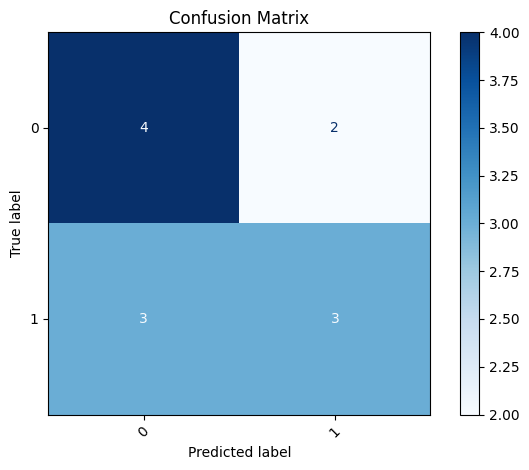

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
class_names = label_encoder.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

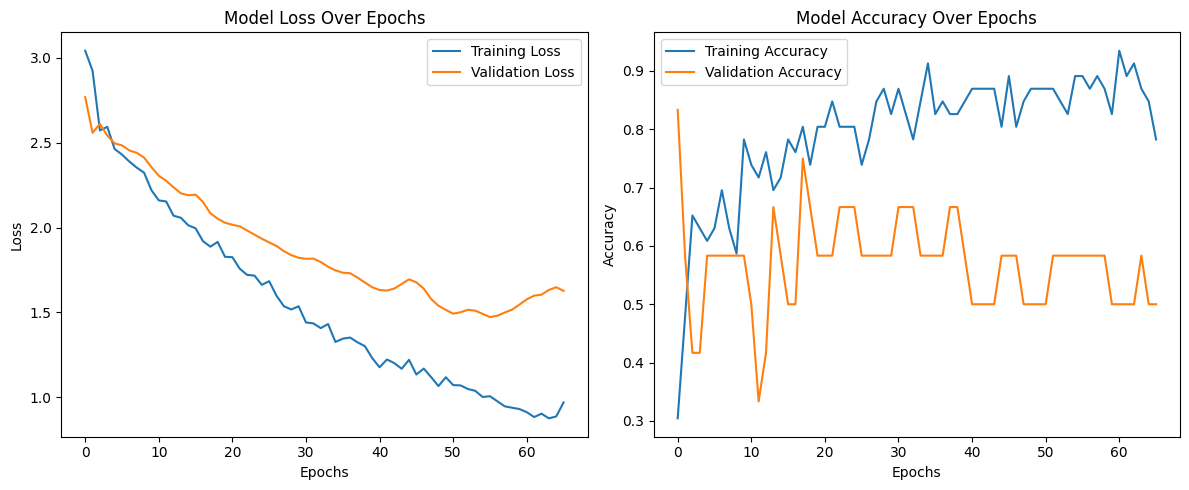

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

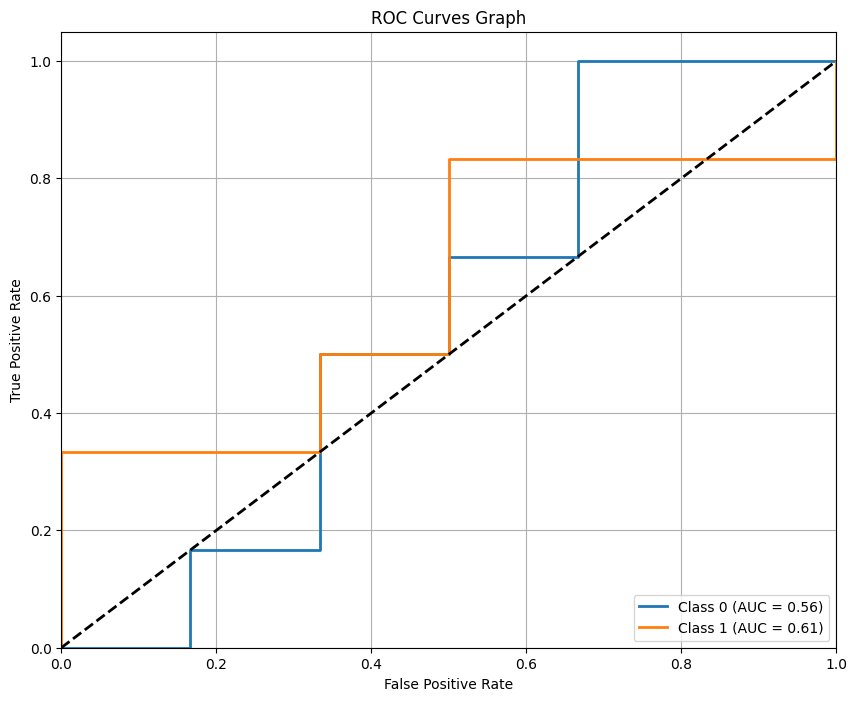

In [17]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, 
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Graph')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

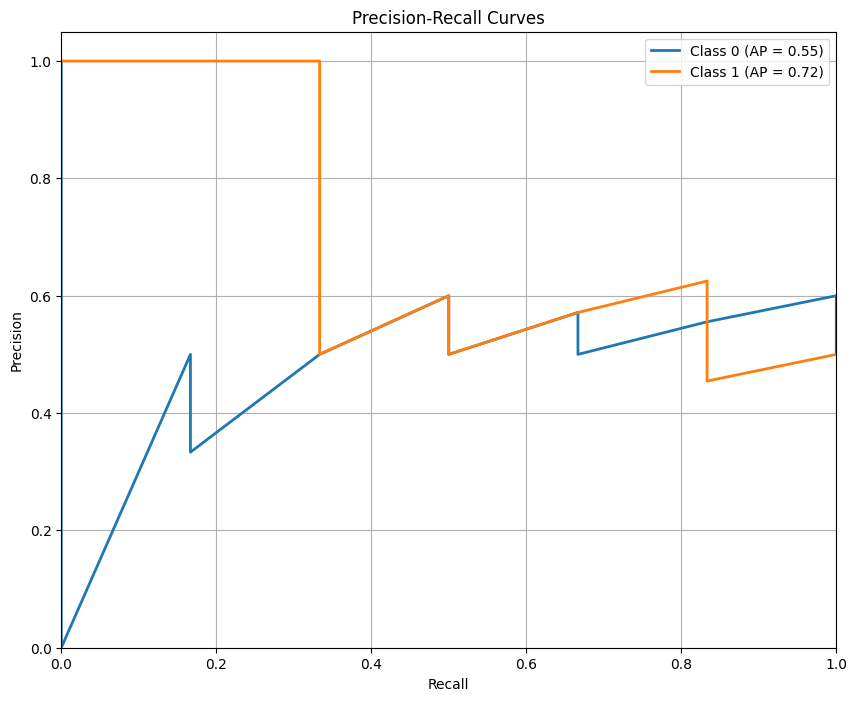

In [18]:
plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    avg_precision = average_precision_score(y_test[:, i], y_pred[:, i])
    plt.plot(recall, precision, lw=2,
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AP = {avg_precision:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [19]:
!pip install keras-tuner

In [ ]:
import keras_tuner as kt

def build_saint_model(hp):
    input_size = x_train_norm.shape[1]
    output_size = y_train.shape[1]

    embedding_dim = hp.Choice('embedding_dim', values=[16, 32, 64])
    input_embeddings = layers.Input(shape=(input_size,))
    embeddings = layers.Embedding(input_dim=1000, output_dim=embedding_dim)(input_embeddings)

    embeddings = layers.Reshape((input_size, embedding_dim))(embeddings)

    self_attention = layers.MultiHeadAttention(
        num_heads=hp.Choice('num_heads', values=[2, 4, 8]),
        key_dim=embedding_dim
    )(embeddings, embeddings)
    self_attention = layers.Dropout(hp.Choice('dropout_1', values=[0.1, 0.2, 0.3]))(self_attention)
    self_attention = layers.LayerNormalization(epsilon=1e-6)(self_attention + embeddings)

    intersample_attention = layers.MultiHeadAttention(
        num_heads=hp.Choice('num_heads', values=[2, 4, 8]),
        key_dim=embedding_dim
    )(self_attention, self_attention)
    intersample_attention = layers.Dropout(hp.Choice('dropout_2', values=[0.1, 0.2, 0.3]))(intersample_attention)
    intersample_attention = layers.LayerNormalization(epsilon=1e-6)(intersample_attention + self_attention)

    flattened = layers.Flatten()(intersample_attention)
    dense_1 = layers.Dense(
        units=hp.Choice('units_1', values=[64, 128, 256]),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01)
    )(flattened)
    dropout_1 = layers.Dropout(hp.Choice('dropout_3', values=[0.3, 0.4, 0.5]))(dense_1)
    output = layers.Dense(output_size, activation='sigmoid')(dropout_1)

    model = models.Model(inputs=input_embeddings, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.001, 0.005, 0.01])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = kt.Hyperband(
    build_saint_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='SAINT_Tuning',
    project_name='SAINT_Hyperparameter_Tuning'
)

hyper_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(
    x_train_norm, y_train,
    validation_data=(x_test_norm, y_test),
    epochs=150,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[hyper_early_stopping],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"Number of Heads: {best_hps.get('num_heads')}")
print(f"Dropout in Self-Attention Block: {best_hps.get('dropout_1')}")
print(f"Dropout in Intersample Attention Block: {best_hps.get('dropout_2')}")
print(f"Units in Dense Layer: {best_hps.get('units_1')}")
print(f"Dropout in Dense Layer: {best_hps.get('dropout_3')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    x_train_norm, y_train,
    validation_data=(x_test_norm, y_test),
    epochs=150,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[hyper_early_stopping],
    verbose=1
)

y_pred_best = best_model.predict(x_test_norm)
y_pred_best_classes = np.argmax(y_pred_best, axis=1)
y_true_best_classes = np.argmax(y_test, axis=1)

Trial 90 Complete [00h 00m 10s]
val_accuracy: 0.6666666865348816

Best val_accuracy So Far: 0.8333333134651184
Total elapsed time: 00h 08m 06s
Best Hyperparameters:
Embedding Dimension: 16
Number of Heads: 4
Dropout in Self-Attention Block: 0.2
Dropout in Intersample Attention Block: 0.3
Units in Dense Layer: 64
Dropout in Dense Layer: 0.4
Learning Rate: 0.005
Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.4461 - loss: 1.8516 - val_accuracy: 0.5833 - val_loss: 1.6214
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5168 - loss: 1.7858 - val_accuracy: 0.5000 - val_loss: 1.6068
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5602 - loss: 1.5444 - val_accuracy: 0.5833 - val_loss: 1.5021
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4316 - loss: 1.5443 - val_accuracy: 0.5833 - val_loss: 1.4349
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5498 - loss: 1.4632 - val_accuracy: 0.5000 - val_loss: 1.3889
Epoch 

In [21]:
print("Classification Report:")
print(classification_report(y_true_best_classes, y_pred_best_classes))

accuracy = accuracy_score(y_true_best_classes, y_pred_best_classes)
roc_auc = roc_auc_score(y_test, y_pred_best, multi_class='ovr', average='weighted')
precision = precision_score(y_true_best_classes, y_pred_best_classes, average='macro')
recall = recall_score(y_true_best_classes, y_pred_best_classes, average='macro')
f1 = f1_score(y_true_best_classes, y_pred_best_classes, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.50      0.55         6
           1       0.57      0.67      0.62         6

    accuracy                           0.58        12
   macro avg       0.59      0.58      0.58        12
weighted avg       0.59      0.58      0.58        12

Accuracy: 0.58
ROC-AUC Score: 0.58
Precision: 0.59
Recall: 0.58
F1-Score: 0.58


<Figure size 1000x800 with 0 Axes>

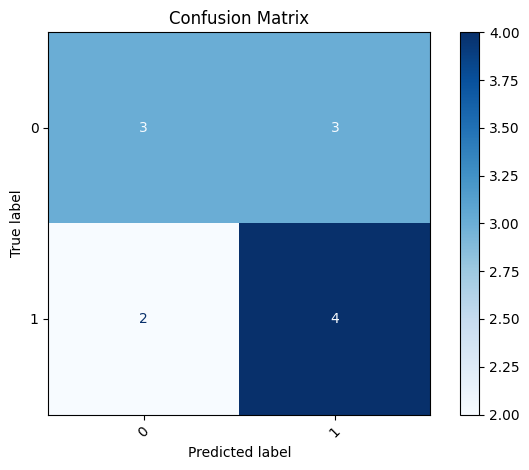

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_best_classes, y_pred_best_classes)

plt.figure(figsize=(10, 8))
class_names = label_encoder.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

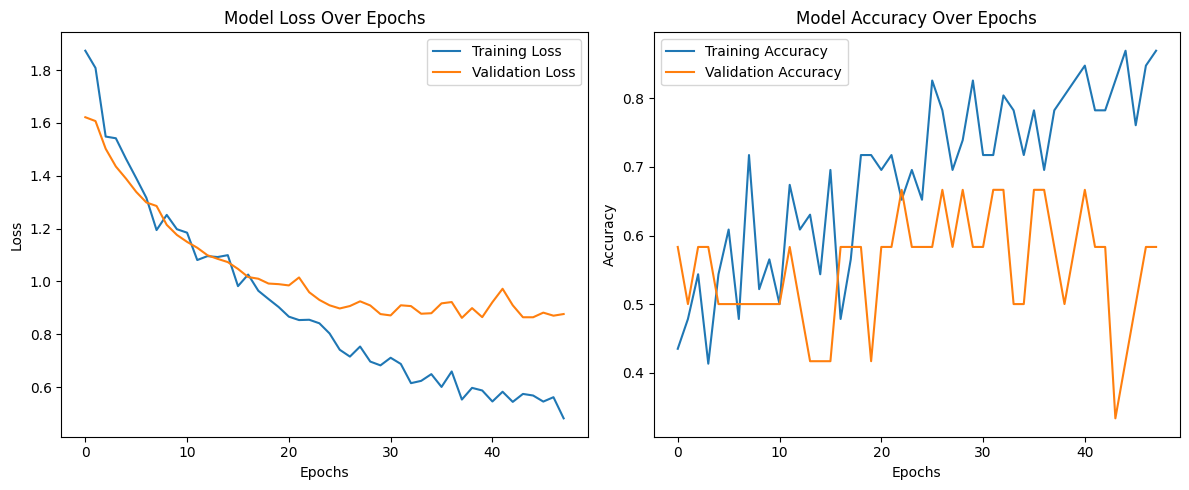

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

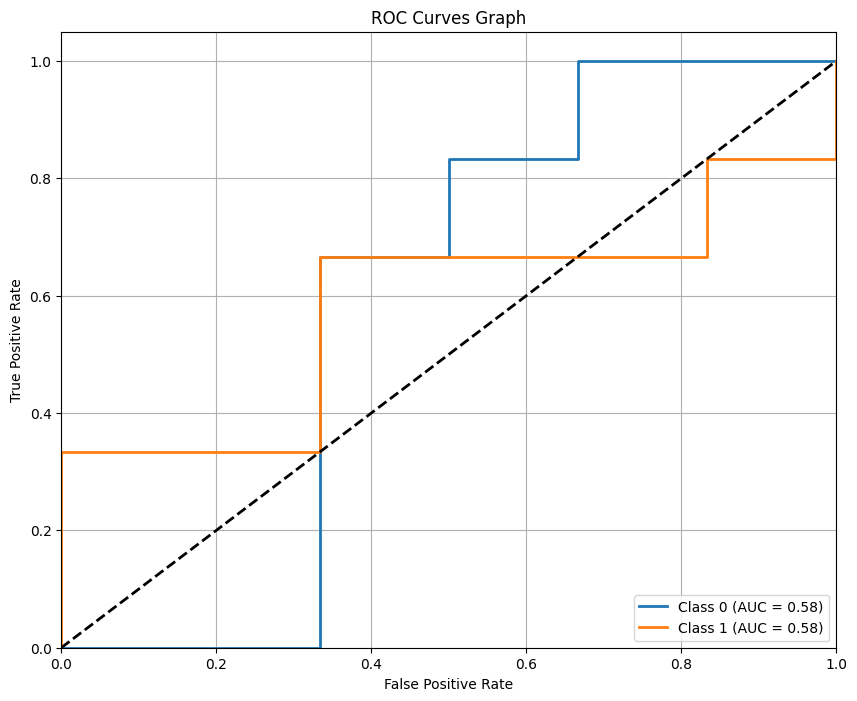

In [24]:
plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_best[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, 
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Graph')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

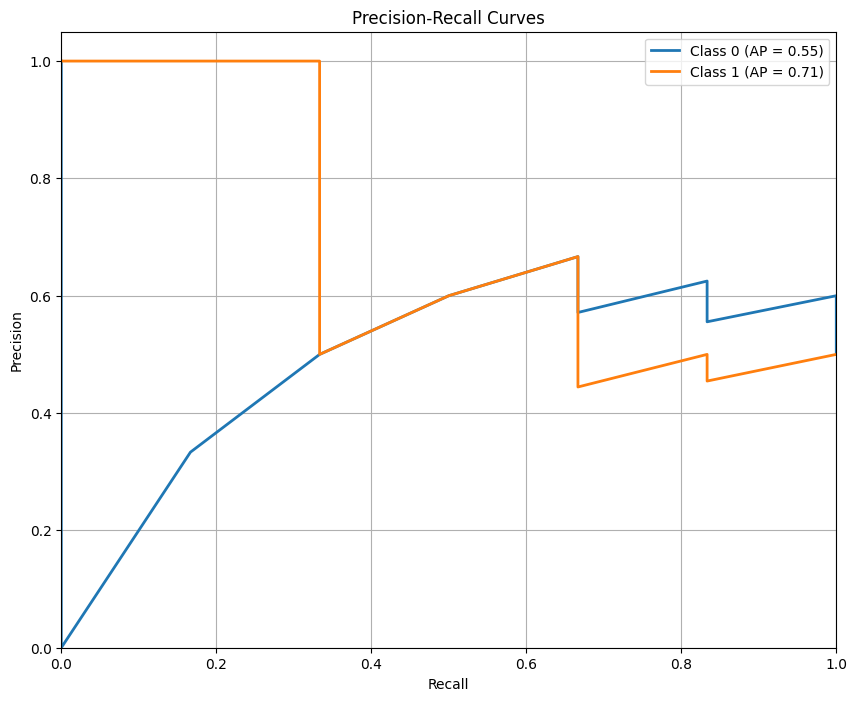

In [25]:
plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_best[:, i])
    avg_precision = average_precision_score(y_test[:, i], y_pred_best[:, i])
    plt.plot(recall, precision, lw=2,
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AP = {avg_precision:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [26]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 13, 32)    │     32,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 13, 32)    │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 13, 32)    │     16,800 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 13, 32)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 13, 32)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 13, 32)    │         64 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 13, 32)    │     16,800 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 13, 32)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 13, 32)    │          0 │ dropout_3[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 13, 32)    │         64 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 416)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     53,376 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2)         │        258 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 358,088 (1.37 MB)

 Trainable params: 119,362 (466.26 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 238,726 (932.53 KB)

In [27]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 13, 16)    │     16,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 13, 16)    │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 13, 16)    │      4,304 │ reshape_1[0][0],  │
│ (MultiHeadAttentio… │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 13, 16)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 13, 16)    │          0 │ dropout_6[0][0],  │
│                     │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 13, 16)    │         32 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 13, 16)    │      4,304 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 13, 16)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 13, 16)    │          0 │ dropout_8[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 13, 16)    │         32 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 208)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     13,376 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │        130 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 114,536 (447.41 KB)

 Trainable params: 38,178 (149.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 76,358 (298.28 KB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


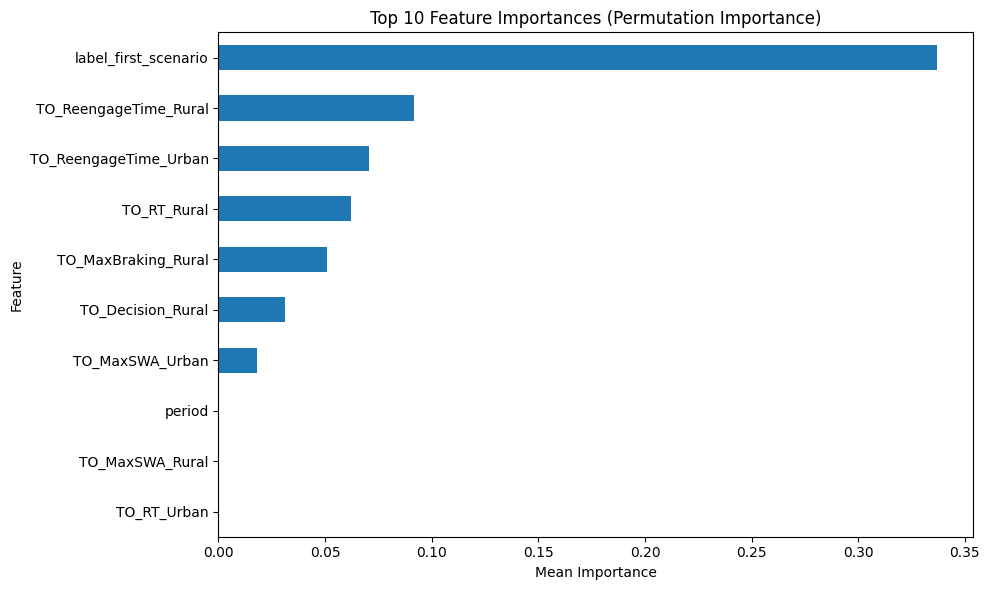

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']

perm_importance = permutation_importance(
    best_model,
    x_test_norm,
    y_test,
    scoring=scoring,
    n_repeats=1,
    random_state=42
)

feature_names = data.drop(columns=['subject_id', 'label_sleep']).columns

feature_importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_importance['r2']['importances_mean']
}).sort_values(by="Importance", ascending=False)

feature_importances.head(10).plot(
    kind="barh",
    x="Feature",
    y="Importance",
    legend=False,
    figsize=(10, 6)
)
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Permutation Importance)")
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
